# DreamBooth

**Author:** [Sayak Paul](https://twitter.com/RisingSayak), [Chansung Park](https://twitter.com/algo_diver)<br>
**Date created:** 2023/02/01<br>
**Last modified:** 2023/02/05<br>
**Description:** Implementing DreamBooth.

## Introduction

In this example, we implement DreamBooth, a fine-tuning technique to teach new visual
concepts to text-conditioned Diffusion models with just 3 - 5 images. DreamBooth was
proposed in
[DreamBooth: Fine Tuning Text-to-Image Diffusion Models for Subject-Driven Generation](https://arxiv.org/abs/2208.12242)
by Ruiz et al.

DreamBooth, in a sense, is similar to the
[traditional way of fine-tuning a text-conditioned Diffusion model except](https://keras.io/examples/generative/finetune_stable_diffusion/)
for a few gotchas. This example assumes that you have basic familiarity with
Diffusion models and how to fine-tune them. Here are some reference examples that might
help you to get familiarized quickly:

* [High-performance image generation using Stable Diffusion in KerasCV](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/)
* [Teach StableDiffusion new concepts via Textual Inversion](https://keras.io/examples/generative/fine_tune_via_textual_inversion/)
* [Fine-tuning Stable Diffusion](https://keras.io/examples/generative/finetune_stable_diffusion/)

First, let's install the latest versions of KerasCV and TensorFlow.

In [1]:
pip install tensorflow==2.15.0 keras==2.15.0 keras-cv==0.6.0, tensorflow_datasets==4.9.6 keras_core==0.1.7

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


If you're running the code, please ensure you're using a GPU with at least 24 GBs of
VRAM.

## Initial imports

In [2]:
import math

import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from imutils import paths
from tensorflow import keras

2025-02-11 14:25:43.349692: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-11 14:25:44.091552: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-11 14:25:44.091640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-11 14:25:44.219128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-11 14:25:44.465965: I tensorflow/core/platform/cpu_feature_guar

Using TensorFlow backend


In [3]:
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

## Usage of DreamBooth

... is very versatile. By teaching Stable Diffusion about your favorite visual
concepts, you can

* Recontextualize objects in interesting ways:

  ![](https://i.imgur.com/4Da9ozw.png)

* Generate artistic renderings of the underlying visual concept:

  ![](https://i.imgur.com/nI2N8bI.png)


And many other applications. We welcome you to check out the original
[DreamBooth paper](https://arxiv.org/abs/2208.12242) in this regard.

## Download the instance and class images

DreamBooth uses a technique called "prior preservation" to meaningfully guide the
training procedure such that the fine-tuned models can still preserve some of the prior
semantics of the visual concept you're introducing. To know more about the idea of "prior
preservation" refer to [this document](https://dreambooth.github.io/).

Here, we need to introduce a few key terms specific to DreamBooth:

* **Unique class**: Examples include "dog", "person", etc. In this example, we use "dog".
* **Unique identifier**: A unique identifier that is prepended to the unique class while
forming the "instance prompts". In this example, we use "sks" as this unique identifier.
* **Instance prompt**: Denotes a prompt that best describes the "instance images". An
example prompt could be - "f"a photo of {unique_id} {unique_class}". So, for our example,
this becomes - "a photo  of sks dog".
* **Class prompt**: Denotes a prompt without the unique identifier. This prompt is used
for generating "class images" for prior preservation. For our example, this prompt is -
"a photo of dog".
* **Instance images**: Denote the images that represent the visual concept you're trying
to teach aka the "instance prompt". This number is typically just 3 - 5. We typically
gather these images ourselves.
* **Class images**: Denote the images generated using the "class prompt" for using prior
preservation in DreamBooth training. We leverage the pre-trained model before fine-tuning
it to generate these class images. Typically, 200 - 300 class images are enough.

In code, this generation process looks quite simply:

```py
from tqdm import tqdm
import numpy as np
import hashlib
import keras_cv
import PIL
import os

class_images_dir = "class-images"
os.makedirs(class_images_dir, exist_ok=True)

model = keras_cv.models.StableDiffusion(img_width=512, img_height=512, jit_compile=True)

class_prompt = "a photo of dog"
num_imgs_to_generate = 200
for i in tqdm(range(num_imgs_to_generate)):
    images = model.text_to_image(
        class_prompt,
        batch_size=3,
    )
    idx = np.random.choice(len(images))
    selected_image = PIL.Image.fromarray(images[idx])
    hash_image = hashlib.sha1(selected_image.tobytes()).hexdigest()
    image_filename = os.path.join(class_images_dir, f"{hash_image}.jpg")
    selected_image.save(image_filename)
```

To keep the runtime of this example short, the authors of this example have gone ahead
and generated some class images using
[this notebook](https://colab.research.google.com/gist/sayakpaul/6b5de345d29cf5860f84b6d04d958692/generate_class_priors.ipynb).

**Note** that prior preservation is an optional technique used in DreamBooth, but it
almost always helps in improving the quality of the generated images.

In [3]:
# If you receive IsADirectory Error, that likely means that datasets are already imported, no need for any changes
instance_images_root = tf.keras.utils.get_file(
    origin="https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/instance-images.tar.gz",
    untar=True,
)
class_images_root = tf.keras.utils.get_file(
    origin="https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/class-images.tar.gz",
    untar=True,
)

## Visualize images

First, let's load the image paths.

In [4]:
instance_image_paths = list(paths.list_images(instance_images_root))
class_image_paths = list(paths.list_images(class_images_root))

Then we load the images from the paths.

In [5]:

def load_images(image_paths):
    images = [np.array(keras.utils.load_img(path)) for path in image_paths]
    return images


And then we make use a utility function to plot the loaded images.

In [6]:

def plot_images(images, title=None):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        if title is not None:
            plt.title(title)
        plt.imshow(images[i])
        plt.axis("off")


**Instance images**:

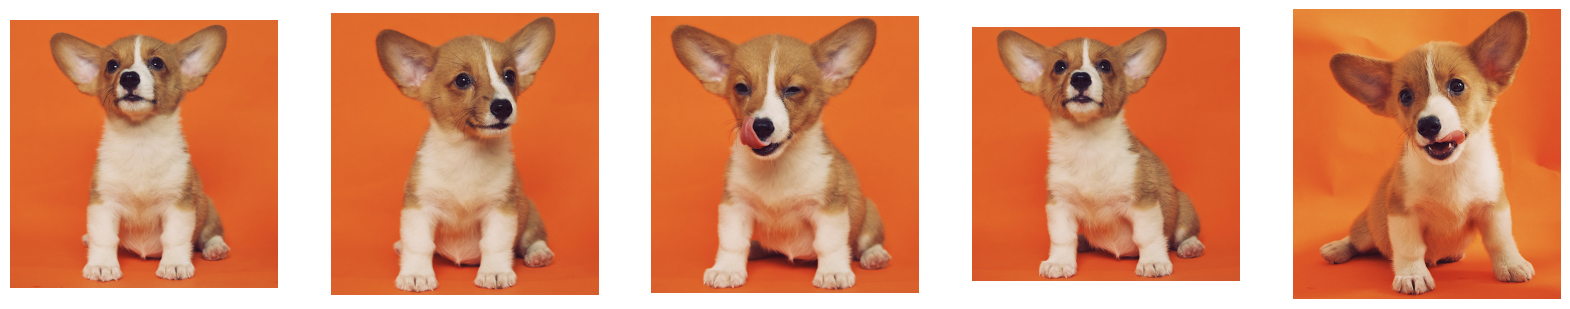

In [8]:
plot_images(load_images(instance_image_paths[:5]))

**Class images**:

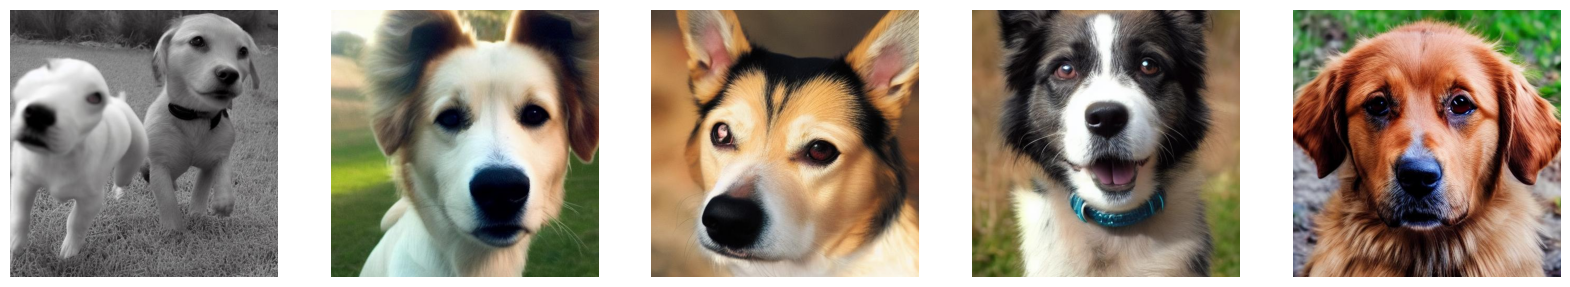

In [8]:
plot_images(load_images(class_image_paths[:5]))

## Prepare datasets

Dataset preparation includes two stages: (1): preparing the captions, (2) processing the
images.

### Prepare the captions

In [7]:
# Since we're using prior preservation, we need to match the number
# of instance images we're using. We just repeat the instance image paths
# to do so.
new_instance_image_paths = []
for index in range(len(class_image_paths)):
    instance_image = instance_image_paths[index % len(instance_image_paths)]
    new_instance_image_paths.append(instance_image)

# We just repeat the prompts / captions per images.
unique_id = "sks"
class_label = "dog"

instance_prompt = f"a photo of {unique_id} {class_label}"
instance_prompts = [instance_prompt] * len(new_instance_image_paths)

class_prompt = f"a photo of {class_label}"
class_prompts = [class_prompt] * len(class_image_paths)

Next, we embed the prompts to save some compute.

In [9]:
import itertools

# The padding token and maximum prompt length are specific to the text encoder.
# If you're using a different text encoder be sure to change them accordingly.
padding_token = 49407
max_prompt_length = 77

# Load the tokenizer.
tokenizer = keras_cv.models.stable_diffusion.SimpleTokenizer()

# Method to tokenize and pad the tokens.
def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [padding_token] * (max_prompt_length - len(tokens))
    return np.array(tokens)

#
# Collate the tokenized captions into an array.
tokenized_texts = np.empty(
    (len(instance_prompts) + len(class_prompts), max_prompt_length)
)

for i, caption in enumerate(itertools.chain(instance_prompts, class_prompts)):
    tokenized_texts[i] = process_text(caption)


# We also pre-compute the text embeddings to save some memory during training.
POS_IDS = tf.convert_to_tensor([list(range(max_prompt_length))], dtype=tf.int32)
text_encoder = keras_cv.models.stable_diffusion.TextEncoder(max_prompt_length)

gpus = tf.config.list_logical_devices("GPU")

# Ensure the computation takes place on a GPU.
# Note that it's done automatically when there's a GPU present.
# This example just attempts at showing how you can do it
# more explicitly.

with tf.device(gpus[0].name):
    embedded_text = text_encoder(
        [tf.convert_to_tensor(tokenized_texts), POS_IDS], training=False
    ).numpy()

# To ensure text_encoder doesn't occupy any GPU space.
del text_encoder

## Prepare the images

In [8]:
resolution = 512
auto = tf.data.AUTOTUNE

augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.CenterCrop(resolution, resolution),
        keras_cv.layers.RandomFlip(),
        keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ]
)


def process_image(image_path, tokenized_text):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, (resolution, resolution))
    return image, tokenized_text


def apply_augmentation(image_batch, embedded_tokens):
    return augmenter(image_batch), embedded_tokens


def prepare_dict(instance_only=True):
    def fn(image_batch, embedded_tokens):
        if instance_only:
            batch_dict = {
                "instance_images": image_batch,
                "instance_embedded_texts": embedded_tokens,
            }
            return batch_dict
        else:
            batch_dict = {
                "class_images": image_batch,
                "class_embedded_texts": embedded_tokens,
            }
            return batch_dict

    return fn


def assemble_dataset(image_paths, embedded_texts, instance_only=True, batch_size=1):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, embedded_texts))
    dataset = dataset.map(process_image, num_parallel_calls=auto)
    dataset = dataset.shuffle(5, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(apply_augmentation, num_parallel_calls=auto)

    prepare_dict_fn = prepare_dict(instance_only=instance_only)
    dataset = dataset.map(prepare_dict_fn, num_parallel_calls=auto)
    return dataset


2025-02-11 14:28:02.123389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20966 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:8c:00.0, compute capability: 8.9


## Assemble dataset

In [10]:
instance_dataset = assemble_dataset(
    new_instance_image_paths,
    embedded_text[: len(new_instance_image_paths)],
)
class_dataset = assemble_dataset(
    class_image_paths,
    embedded_text[len(new_instance_image_paths) :],
    instance_only=False,
)
train_dataset = tf.data.Dataset.zip((instance_dataset, class_dataset))

## Check shapes

Now that the dataset has been prepared, let's quickly check what's inside it.

In [11]:
sample_batch = next(iter(train_dataset))
print(sample_batch[0].keys(), sample_batch[1].keys())

for k in sample_batch[0]:
    print(k, sample_batch[0][k].shape)

for k in sample_batch[1]:
    print(k, sample_batch[1][k].shape)

2025-02-11 14:29:16.430256: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10435300046845413660


dict_keys(['instance_images', 'instance_embedded_texts']) dict_keys(['class_images', 'class_embedded_texts'])
instance_images (1, 512, 512, 3)
instance_embedded_texts (1, 77, 768)
class_images (1, 512, 512, 3)
class_embedded_texts (1, 77, 768)


During training, we make use of these keys to gather the images and text embeddings and
concat them accordingly.

## DreamBooth training loop

Our DreamBooth training loop is very much inspired by
[this script](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth.py)
provided by the Diffusers team at Hugging Face. However, there is an important
difference to note. We only fine-tune the UNet (the model responsible for predicting
noise) and don't fine-tune the text encoder in this example. If you're looking for an
implementation that also performs the additional fine-tuning of the text encoder, refer
to [this repository](https://github.com/sayakpaul/dreambooth-keras/).

In [19]:
import tensorflow.experimental.numpy as tnp


class DreamBoothTrainer(tf.keras.Model):
    # Reference:
    # https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth.py

    def __init__(
        self,
        diffusion_model,
        vae,
        noise_scheduler,
        use_mixed_precision=False,
        prior_loss_weight=1.0,
        max_grad_norm=1.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.diffusion_model = diffusion_model
        self.vae = vae
        self.noise_scheduler = noise_scheduler
        self.prior_loss_weight = prior_loss_weight
        self.max_grad_norm = max_grad_norm

        self.use_mixed_precision = use_mixed_precision
        self.vae.trainable = False

    def train_step(self, inputs):
        instance_batch = inputs[0]
        class_batch = inputs[1]

        instance_images = instance_batch["instance_images"]
        instance_embedded_text = instance_batch["instance_embedded_texts"]
        class_images = class_batch["class_images"]
        class_embedded_text = class_batch["class_embedded_texts"]

        images = tf.concat([instance_images, class_images], 0)
        embedded_texts = tf.concat([instance_embedded_text, class_embedded_text], 0)
        with open("batch.log", "a") as fout:
            fout.write(str(tf.shape(images)))
        batch_size = 1

        with tf.GradientTape() as tape:
            # Project image into the latent space and sample from it.
            latents = self.sample_from_encoder_outputs(self.vae(images, training=False))
            # Know more about the magic number here:
            # https://keras.io/examples/generative/fine_tune_via_textual_inversion/
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents.
            noise = tf.random.normal(tf.shape(latents))

            # Sample a random timestep for each image.
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process).
            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )

            # Get the target for loss depending on the prediction type
            # just the sampled noise for now.
            target = noise  # noise_schedule.predict_epsilon == True

            # Predict the noise residual and compute loss.
            timestep_embedding = tf.map_fn(
                lambda t: self.get_timestep_embedding(t), timesteps, dtype=tf.float32
            )
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, embedded_texts], training=True
            )
            loss = self.compute_loss(target, model_pred)
            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        # Update parameters of the diffusion model.
        trainable_vars = self.diffusion_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        if self.use_mixed_precision:
            gradients = self.optimizer.get_unscaled_gradients(gradients)
        gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        log_max_period = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_period * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        return embedding

    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
        return mean + std * sample

    def compute_loss(self, target, model_pred):
        # Chunk the noise and model_pred into two parts and compute the loss
        # on each part separately.
        # Since the first half of the inputs has instance samples and the second half
        # has class samples, we do the chunking accordingly.
        model_pred, model_pred_prior = tf.split(
            model_pred, num_or_size_splits=2, axis=0
        )
        target, target_prior = tf.split(target, num_or_size_splits=2, axis=0)

        # Compute instance loss.
        loss = self.compiled_loss(target, model_pred)

        # Compute prior loss.
        prior_loss = self.compiled_loss(target_prior, model_pred_prior)

        # Add the prior loss to the instance loss.
        loss = loss + self.prior_loss_weight * prior_loss
        return loss

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        # Overriding this method will allow us to use the `ModelCheckpoint`
        # callback directly with this trainer class. In this case, it will
        # only checkpoint the `diffusion_model` since that's what we're training
        # during fine-tuning.
        self.diffusion_model.save_weights(
            filepath=filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        # Similarly override `load_weights()` so that we can directly call it on
        # the trainer class object.
        self.diffusion_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )


## Trainer initialization

In [20]:
# Comment it if you are not using a GPU having tensor cores.
tf.keras.mixed_precision.set_global_policy("mixed_float16")

use_mp = True  # Set it to False if you're not using a GPU with tensor cores.

image_encoder = keras_cv.models.stable_diffusion.ImageEncoder()
dreambooth_trainer = DreamBoothTrainer(
    diffusion_model=keras_cv.models.stable_diffusion.DiffusionModel(
        resolution, resolution, max_prompt_length
    ),
    # Remove the top layer from the encoder, which cuts off the variance and only
    # returns the mean.
    vae=tf.keras.Model(
        image_encoder.input,
        image_encoder.layers[-2].output,
    ),
    noise_scheduler=keras_cv.models.stable_diffusion.NoiseScheduler(),
    use_mixed_precision=use_mp,
)

# These hyperparameters come from this tutorial by Hugging Face:
# https://github.com/huggingface/diffusers/tree/main/examples/dreambooth
learning_rate = 5e-6
beta_1, beta_2 = 0.9, 0.999
weight_decay = (1e-2,)
epsilon = 1e-08

optimizer = tf.keras.optimizers.experimental.AdamW(
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    beta_1=beta_1,
    beta_2=beta_2,
    epsilon=epsilon,
)
dreambooth_trainer.compile(optimizer=optimizer, loss="mse")

## Train!

We first calculate the number of epochs, we need to train for.

In [21]:
num_update_steps_per_epoch = train_dataset.cardinality()
max_train_steps = 800
epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)
print(f"Training for {epochs} epochs.")

Training for 4 epochs.


And then we start training!

In [22]:
ckpt_path = "dreambooth-unet.h5"
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    save_weights_only=True,
    monitor="loss",
    mode="min",
)
dreambooth_trainer.fit(train_dataset, epochs=epochs, callbacks=[ckpt_callback])

Epoch 1/4


2025-02-11 14:39:33.687037: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 112.50MiB (rounded to 117964800)requested by op Fill
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-02-11 14:39:33.687174: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2025-02-11 14:39:33.687195: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 267, Chunks in use: 266. 66.8KiB allocated for chunks. 66.5KiB in use in bin. 2.0KiB client-requested in use in bin.
2025-02-11 14:39:33.687205: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 50, Chunks in use: 50. 25.5KiB allocated for chunks. 25.5KiB in use in bin. 24.9KiB client-requested in use in bin.
2025-02-11 14:39:33.68

ResourceExhaustedError: in user code:

    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/tmp/ipykernel_3945/4024854475.py", line 86, in train_step
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/src/mixed_precision/loss_scale_optimizer.py", line 1275, in apply_gradients
        self.build(trainable_variables)
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/src/mixed_precision/loss_scale_optimizer.py", line 1414, in build
        return self._optimizer.build(var_list)
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/src/optimizers/adamw.py", line 149, in build
        self.add_variable_from_reference(
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 1125, in add_variable_from_reference
        return super().add_variable_from_reference(
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 508, in add_variable_from_reference
        initial_value = tf.zeros(
    File "/home/jupyter/.local/lib/python3.10/site-packages/tensorflow/dtensor/python/api.py", line 64, in call_with_layout
        return fn(*args, **kwargs)

    ResourceExhaustedError: {{function_node __wrapped__Fill_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[3,3,2560,1280] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill] name: 


## Experiments and inference

We ran various experiments with a slightly modified version of this example. Our
experiments are based on
[this repository](https://github.com/sayakpaul/dreambooth-keras/) and are inspired by
[this blog post](https://huggingface.co/blog/dreambooth) from Hugging Face.

First, let's see how we can use the fine-tuned checkpoint for running inference.

In [ ]:
# Initialize a new Stable Diffusion model.
dreambooth_model = keras_cv.models.StableDiffusion(
    img_width=resolution, img_height=resolution, jit_compile=True
)
dreambooth_model.diffusion_model.load_weights(ckpt_path)

# Note how the unique identifier and the class have been used in the prompt.
prompt = f"A photo of {unique_id} {class_label} in a bucket"
num_imgs_to_gen = 3

images_dreamboothed = dreambooth_model.text_to_image(prompt, batch_size=num_imgs_to_gen)
plot_images(images_dreamboothed, prompt)

Now, let's load checkpoints from a different experiment we conducted where we also
fine-tuned the text encoder along with the UNet:

In [ ]:
unet_weights = tf.keras.utils.get_file(
    origin="https://huggingface.co/chansung/dreambooth-dog/resolve/main/lr%409e-06-max_train_steps%40200-train_text_encoder%40True-unet.h5"
)
text_encoder_weights = tf.keras.utils.get_file(
    origin="https://huggingface.co/chansung/dreambooth-dog/resolve/main/lr%409e-06-max_train_steps%40200-train_text_encoder%40True-text_encoder.h5"
)

dreambooth_model.diffusion_model.load_weights(unet_weights)
dreambooth_model.text_encoder.load_weights(text_encoder_weights)

images_dreamboothed = dreambooth_model.text_to_image(prompt, batch_size=num_imgs_to_gen)
plot_images(images_dreamboothed, prompt)

The default number of steps for generating an image in `text_to_image()`
[is 50](https://github.com/keras-team/keras-cv/blob/3575bc3b944564fe15b46b917e6555aa6a9d7be0/keras_cv/models/stable_diffusion/stable_diffusion.py#L73).
Let's increase it to 100.

In [ ]:
images_dreamboothed = dreambooth_model.text_to_image(
    prompt, batch_size=num_imgs_to_gen, num_steps=100
)
plot_images(images_dreamboothed, prompt)

Feel free to experiment with different prompts (don't forget to add the unique identifier
and the class label!) to see how the results change. We welcome you to check out our
codebase and more experimental results
[here](https://github.com/sayakpaul/dreambooth-keras#results). You can also read
[this blog post](https://huggingface.co/blog/dreambooth) to get more ideas.

## Acknowledgements

* Thanks to the
[DreamBooth example script](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth.py)
provided by Hugging Face which helped us a lot in getting the initial implementation
ready quickly.
* Getting DreamBooth to work on human faces can be challenging. We have compiled some
general recommendations
[here](https://github.com/sayakpaul/dreambooth-keras#notes-on-preparing-data-for-dreambooth-training-of-faces).
Thanks to
[Abhishek Thakur](https://no.linkedin.com/in/abhi1thakur)
for helping with these.